In [13]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [14]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2000-01-01,0.751094
1,AAPL,2000-01-08,0.758171
2,AAPL,2000-01-15,0.840263
3,AAPL,2000-01-22,0.767135
4,AAPL,2000-01-29,0.815258
...,...,...,...
8611,NVDA,2024-07-06,129.240005
8612,NVDA,2024-07-13,117.930000
8613,NVDA,2024-07-20,113.059998
8614,NVDA,2024-07-27,117.019997


In [15]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [16]:
season_length = 52 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [17]:
# Generate forecasts for the specified horizon using the sf object
horizon = 12
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) # forecast data
Y_hat_df.head(5) 

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-01,128.615738,128.575714,128.583359,128.756363
AAPL,2023-01-08,128.398041,128.590500,128.271072,128.844559
AAPL,2023-01-15,129.448959,128.605286,129.309647,128.851578
AAPL,2023-01-22,129.561707,128.620087,130.797943,129.589996
AAPL,2023-01-29,129.887848,128.634872,131.616821,129.759644


In [18]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  19.985882  460.990222  0.131481  21.470683  14.203231

Model: AutoETS
         mae         mse      mape       rmse     smape:
0  20.502219  485.468325  0.134864  22.033346  14.600315

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  18.291519  383.553942  0.120421  19.584533  12.913901

Model: CES
         mae         mse      mape       rmse     smape:
0  20.371989  480.452679  0.133988  21.919231  14.500621

Results for MSFT:
Model: AutoARIMA
        mae          mse     mape       rmse     smape:
0  38.93361  1833.465776  0.14847  42.818989  16.260779

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  32.859791  1310.819221  0.125266  36.205237  13.518864

Model: AutoTheta
         mae          mse      mape       rmse     smape:
0  36.361118  1552.433182  0.138991  39.400929  15.092331

Model: CES
        mae         mse      mape    

In [19]:
cv_df = sf.cross_validation(df=Y_train_df, h=12, n_windows=3, step_size=12, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-04-30,2022-04-23,155.292313,156.118881,151.694855,160.542923,156.011368,135.020142,177.002579,153.637894,149.775116,157.579269,157.469849,151.067047,163.727402
AAPL,2022-05-07,2022-04-23,145.464264,156.580139,150.301300,162.858963,156.364639,126.567535,186.161743,154.105698,148.380920,160.389725,157.887695,151.673004,164.062271
AAPL,2022-05-14,2022-04-23,136.050751,157.041382,149.324051,164.758698,156.717911,120.086540,193.349289,153.498688,146.547668,160.557510,158.481705,152.208481,164.891281
AAPL,2022-05-21,2022-04-23,147.965942,157.502625,148.559799,166.445450,157.071182,114.613396,199.528976,151.735107,143.113770,160.884720,158.838242,152.559052,165.257233
AAPL,2022-05-28,2022-04-23,143.753616,157.963867,147.930099,167.997650,157.424469,109.776276,205.072647,152.807617,143.069870,161.145325,159.706924,153.206970,165.980240


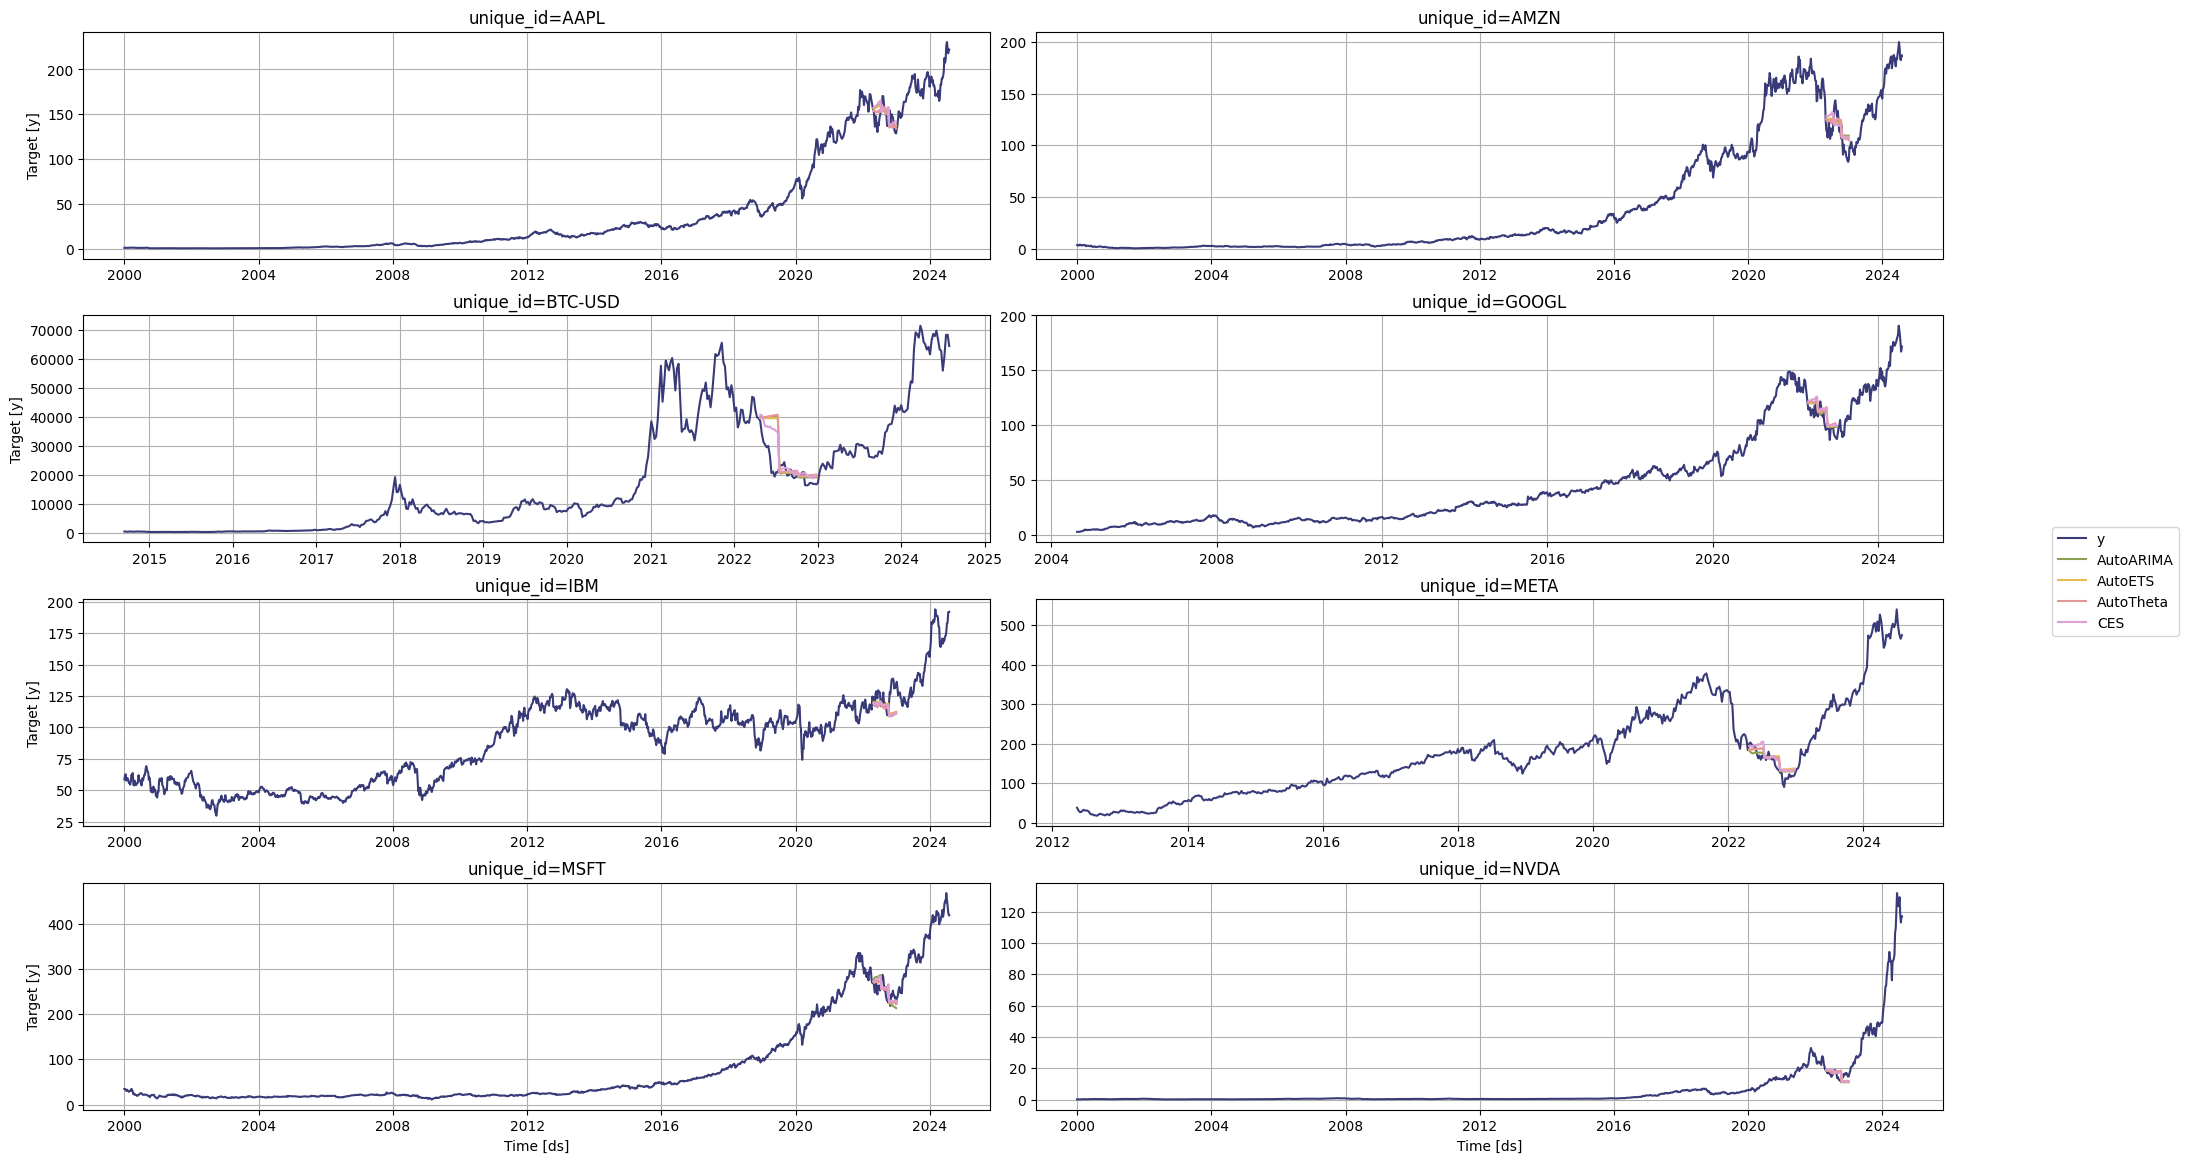

In [20]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))